In [1]:
import keras.callbacks
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
import sklearn
import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

2022-09-28 15:42:03.584867: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# 데이터 불러오기
learn_csv_file = pd.read_csv('csv_files/side_five_class/side_learn.csv')
valid_csv_file = pd.read_csv('csv_files/side_five_class/side_valid.csv')
test_csv_file = pd.read_csv('csv_files/side_five_class/side_test.csv')

learn_csv_file = sklearn.utils.shuffle(learn_csv_file)
valid_csv_file = sklearn.utils.shuffle(valid_csv_file)

col = 34

learn_x = learn_csv_file.iloc[:,:col].values
learn_y = learn_csv_file.iloc[:,col:].values
valid_x = valid_csv_file.iloc[:,:col].values
valid_y = valid_csv_file.iloc[:,col:].values
test_x = test_csv_file.iloc[:,:col].values
test_y = test_csv_file.iloc[:,col:].values

scaler = RobustScaler()
scaler.fit(learn_x)
scaled_learn_x = scaler.transform(learn_x)
scaled_valid_x = scaler.transform(valid_x)
scaled_test_x = scaler.transform(test_x)
joblib.dump(scaler, 'trained_models/scalers/fall_scaler_robust_five_class.pkl')

# one-hot encoding
learn_y = tf.keras.utils.to_categorical(learn_y)
valid_y = tf.keras.utils.to_categorical(valid_y)
test_y = tf.keras.utils.to_categorical(test_y)

In [3]:
# 첫번째 모델 구성 (multi-class classification)
dropout_ratio = 0.5
regulation = 0.01

first_side_model = Sequential()

first_side_model.add(Dense(128, activation='relu', input_shape=(col,), kernel_regularizer=regularizers.l2(regulation)))
first_side_model.add(Dropout(dropout_ratio))
first_side_model.add(Dense(128, activation='relu', input_shape=(col,), kernel_regularizer=regularizers.l2(regulation)))
first_side_model.add(Dropout(dropout_ratio))
first_side_model.add(Dense(5, activation='softmax'))

# 모델 최적화 및 손실 함수 알고리즘 지정
# adam, crossentropy
first_side_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', recall_m, precision_m, f1_m])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)
save_best = keras.callbacks.ModelCheckpoint(filepath='trained_models/side_exp/fall_model_five_class_exp.h5', verbose=1, save_best_only=True, mode='auto', save_freq='epoch')

# 모델 training
first_side_model_after_data = first_side_model.fit(scaled_learn_x, learn_y, batch_size=64, epochs=300, validation_data=(scaled_valid_x, valid_y), callbacks=[early_stop, save_best])

# 모델 test (predict)
print()
predict_result = first_side_model.predict(scaled_test_x)
first_side_model.evaluate(scaled_test_x, test_y)
test_correct = 0
for i in range(len(test_y)):
    if test_y[i].argmax() == predict_result[i].argmax():
        test_correct += 1
print(f"test result correct percent : {test_correct/len(test_y) * 100:.2f}%")


Epoch 1/300


2022-09-28 15:42:04.898892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 15:42:04.921192: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-09-28 15:42:04.921202: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-09-28 15:42:04.921648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

107/155 [===================>..........] - ETA: 0s - loss: 2.3503 - accuracy: 0.6247 - recall_m: 0.3734 - precision_m: 0.8185 - f1_m: 0.5020
Epoch 1: val_loss improved from inf to 1.31741, saving model to trained_models/side_exp/fall_model_five_class_exp.h5
155/155 [==============================] - 1s 2ms/step - loss: 2.0715 - accuracy: 0.6928 - recall_m: 0.4717 - precision_m: 0.8475 - f1_m: 0.5892 - val_loss: 1.3174 - val_accuracy: 0.8079 - val_recall_m: 0.7277 - val_precision_m: 0.8778 - val_f1_m: 0.7950
Epoch 2/300
154/155 [============================>.] - ETA: 0s - loss: 0.9516 - accuracy: 0.8882 - recall_m: 0.8331 - precision_m: 0.9194 - f1_m: 0.8735
Epoch 2: val_loss improved from 1.31741 to 0.82078, saving model to trained_models/side_exp/fall_model_five_class_exp.h5
155/155 [==============================] - 0s 1ms/step - loss: 0.9512 - accuracy: 0.8880 - recall_m: 0.8328 - precision_m: 0.9190 - f1_m: 0.8731 - val_loss: 0.8208 - val_accuracy: 0.8553 - val_recall_m: 0.8182 - v

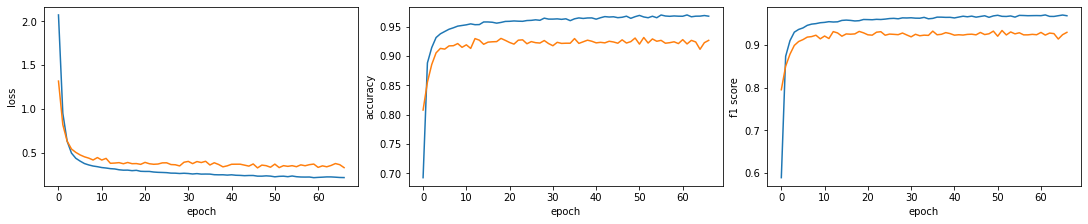

In [4]:
# 시각화
# 손실, 정확도 그래프
plt.subplots(figsize=(15, 3), constrained_layout=True)
plt.subplot(1, 3, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(first_side_model_after_data.history['loss'])
plt.plot(first_side_model_after_data.history['val_loss'])
plt.subplot(1, 3, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(first_side_model_after_data.history['accuracy'])
plt.plot(first_side_model_after_data.history['val_accuracy'])
plt.subplot(1, 3, 3)
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.plot(first_side_model_after_data.history['f1_m'])
plt.plot(first_side_model_after_data.history['val_f1_m'])

plt.show()


In [5]:
# 두번째 모델 구성 (multi-class classification)
# 5층, 노드 (128, 64, 32, 16, 8)
dropout_ratio = 0.5
regulation = 0.01

second_side_model = Sequential()

second_side_model.add(Dense(128, activation='relu', input_shape=(col,), kernel_regularizer=regularizers.l2(regulation)))
second_side_model.add(Dropout(dropout_ratio))
second_side_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(regulation)))
second_side_model.add(Dropout(dropout_ratio))
second_side_model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(regulation)))
second_side_model.add(Dropout(dropout_ratio))
second_side_model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(regulation)))
second_side_model.add(Dropout(dropout_ratio))
second_side_model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(regulation)))
second_side_model.add(Dropout(dropout_ratio))
second_side_model.add(Dense(5, activation='softmax'))

# 모델 최적화 및 손실 함수 알고리즘 지정
# adam, crossentropy
second_side_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', recall_m, precision_m, f1_m])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)
save_best = keras.callbacks.ModelCheckpoint(filepath='trained_models/side_exp/fall_model_five_class_second_exp.h5', verbose=1, save_best_only=True, mode='auto', save_freq='epoch')

# 모델 training
second_side_model_after_data = second_side_model.fit(scaled_learn_x, learn_y, batch_size=64, epochs=300, validation_data=(scaled_valid_x, valid_y), callbacks=[early_stop, save_best])

# 모델 test (predict)
print()
predict_result = second_side_model.predict(scaled_test_x)
second_side_model.evaluate(scaled_test_x, test_y)
test_correct = 0
for i in range(len(test_y)):
    if test_y[i].argmax() == predict_result[i].argmax():
        test_correct += 1
print(f"test result correct percent : {test_correct/len(test_y) * 100:.2f}%")


Epoch 1/300
105/155 [===================>..........] - ETA: 0s - loss: 3.4155 - accuracy: 0.2357 - recall_m: 0.0201 - precision_m: 0.4897 - f1_m: 0.0377
Epoch 1: val_loss improved from inf to 2.67529, saving model to trained_models/side_exp/fall_model_five_class_second_exp.h5
155/155 [==============================] - 1s 2ms/step - loss: 3.2331 - accuracy: 0.2478 - recall_m: 0.0234 - precision_m: 0.5734 - f1_m: 0.0440 - val_loss: 2.6753 - val_accuracy: 0.4328 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/300
121/155 [======================>.......] - ETA: 0s - loss: 2.3465 - accuracy: 0.3869 - recall_m: 0.0852 - precision_m: 0.8036 - f1_m: 0.1508
Epoch 2: val_loss improved from 2.67529 to 1.74706, saving model to trained_models/side_exp/fall_model_five_class_second_exp.h5
155/155 [==============================] - 0s 1ms/step - loss: 2.2671 - accuracy: 0.3967 - recall_m: 0.0999 - precision_m: 0.7973 - f1_m: 0.1731 - val_loss: 1.7471 - val_accur

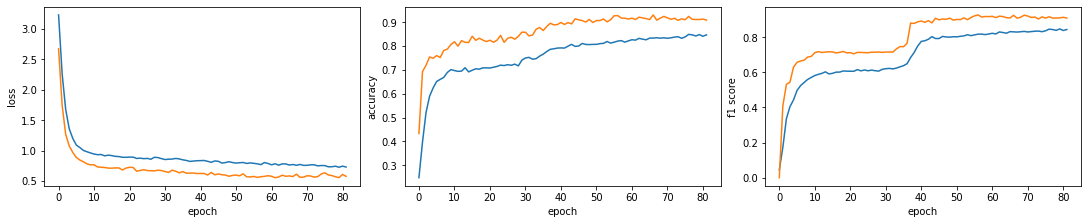

In [6]:
# 시각화
# 손실, 정확도 그래프
plt.subplots(figsize=(15, 3), constrained_layout=True)
plt.subplot(1, 3, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(second_side_model_after_data.history['loss'])
plt.plot(second_side_model_after_data.history['val_loss'])
plt.subplot(1, 3, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(second_side_model_after_data.history['accuracy'])
plt.plot(second_side_model_after_data.history['val_accuracy'])
plt.subplot(1, 3, 3)
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.plot(second_side_model_after_data.history['f1_m'])
plt.plot(second_side_model_after_data.history['val_f1_m'])

plt.show()


In [7]:
# 두번째 모델 구성 (multi-class classification)
# 1층, 노드 (32)
dropout_ratio = 0.5
regulation = 0.01

third_side_model = Sequential()

third_side_model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(regulation)))
third_side_model.add(Dropout(dropout_ratio))
third_side_model.add(Dense(5, activation='softmax'))

# 모델 최적화 및 손실 함수 알고리즘 지정
# adam, crossentropy
third_side_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', recall_m, precision_m, f1_m])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)
save_best = keras.callbacks.ModelCheckpoint(filepath='trained_models/side_exp/fall_model_five_class_third_exp.h5', verbose=1, save_best_only=True, mode='auto', save_freq='epoch')

# 모델 training
third_side_model_after_data = third_side_model.fit(scaled_learn_x, learn_y, batch_size=64, epochs=300, validation_data=(scaled_valid_x, valid_y), callbacks=[early_stop, save_best])

# 모델 test (predict)
print()
predict_result = third_side_model.predict(scaled_test_x)
third_side_model.evaluate(scaled_test_x, test_y)
test_correct = 0
for i in range(len(test_y)):
    if test_y[i].argmax() == predict_result[i].argmax():
        test_correct += 1
print(f"test result correct percent : {test_correct/len(test_y) * 100:.2f}%")


Epoch 1/300
128/155 [=======================>......] - ETA: 0s - loss: 1.6310 - accuracy: 0.4253 - recall_m: 0.2272 - precision_m: 0.6744 - f1_m: 0.3363
Epoch 1: val_loss improved from inf to 1.24041, saving model to trained_models/side_exp/fall_model_five_class_third_exp.h5
155/155 [==============================] - 1s 2ms/step - loss: 1.5633 - accuracy: 0.4616 - recall_m: 0.2475 - precision_m: 0.7099 - f1_m: 0.3632 - val_loss: 1.2404 - val_accuracy: 0.6559 - val_recall_m: 0.2659 - val_precision_m: 0.8527 - val_f1_m: 0.4025
Epoch 2/300
 77/155 [=============>................] - ETA: 0s - loss: 1.1117 - accuracy: 0.7092 - recall_m: 0.4054 - precision_m: 0.8875 - f1_m: 0.5546
Epoch 2: val_loss improved from 1.24041 to 0.96753, saving model to trained_models/side_exp/fall_model_five_class_third_exp.h5
155/155 [==============================] - 0s 1ms/step - loss: 1.0383 - accuracy: 0.7353 - recall_m: 0.4511 - precision_m: 0.8984 - f1_m: 0.5973 - val_loss: 0.9675 - val_accuracy: 0.7422 - 

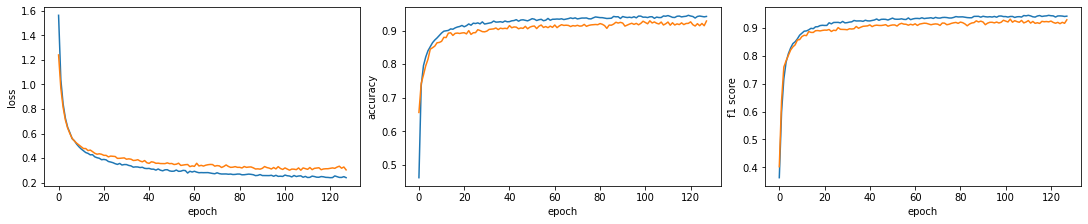

In [8]:
# 시각화
# 손실, 정확도 그래프
plt.subplots(figsize=(15, 3), constrained_layout=True)
plt.subplot(1, 3, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(third_side_model_after_data.history['loss'])
plt.plot(third_side_model_after_data.history['val_loss'])
plt.subplot(1, 3, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(third_side_model_after_data.history['accuracy'])
plt.plot(third_side_model_after_data.history['val_accuracy'])
plt.subplot(1, 3, 3)
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.plot(third_side_model_after_data.history['f1_m'])
plt.plot(third_side_model_after_data.history['val_f1_m'])

plt.show()


In [11]:
# 네번째 모델 구성 (multi-class classification)
# 1층, 노드 (64)
dropout_ratio = 0.5
regulation = 0.01

fourth_side_model = Sequential()

fourth_side_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(regulation)))
fourth_side_model.add(Dropout(dropout_ratio))
fourth_side_model.add(Dense(5, activation='softmax'))

# 모델 최적화 및 손실 함수 알고리즘 지정
# adam, crossentropy
fourth_side_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', recall_m, precision_m, f1_m])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)
save_best = keras.callbacks.ModelCheckpoint(filepath='trained_models/side_exp/fall_model_five_class_fourth_exp.h5', verbose=1, save_best_only=True, mode='auto', save_freq='epoch')

# 모델 training
fourth_side_model_after_data = fourth_side_model.fit(scaled_learn_x, learn_y, batch_size=64, epochs=300, validation_data=(scaled_valid_x, valid_y), callbacks=[early_stop, save_best])

# 모델 test (predict)
print()
predict_result = fourth_side_model.predict(scaled_test_x)
fourth_side_model.evaluate(scaled_test_x, test_y)
test_correct = 0
for i in range(len(test_y)):
    if test_y[i].argmax() == predict_result[i].argmax():
        test_correct += 1
print(f"test result correct percent : {test_correct/len(test_y) * 100:.2f}%")


Epoch 1/300
153/155 [============================>.] - ETA: 0s - loss: 1.4117 - accuracy: 0.5982 - recall_m: 0.3549 - precision_m: 0.8070 - f1_m: 0.4881
Epoch 1: val_loss improved from inf to 1.11931, saving model to trained_models/side_exp/fall_model_five_class_fourth_exp.h5
155/155 [==============================] - 1s 2ms/step - loss: 1.4103 - accuracy: 0.5992 - recall_m: 0.3553 - precision_m: 0.8065 - f1_m: 0.4884 - val_loss: 1.1193 - val_accuracy: 0.7778 - val_recall_m: 0.4773 - val_precision_m: 0.8903 - val_f1_m: 0.6197
Epoch 2/300
 69/155 [============>.................] - ETA: 0s - loss: 0.9316 - accuracy: 0.8349 - recall_m: 0.5713 - precision_m: 0.9280 - f1_m: 0.7047
Epoch 2: val_loss improved from 1.11931 to 0.83222, saving model to trained_models/side_exp/fall_model_five_class_fourth_exp.h5
155/155 [==============================] - 0s 861us/step - loss: 0.8648 - accuracy: 0.8436 - recall_m: 0.6374 - precision_m: 0.9208 - f1_m: 0.7495 - val_loss: 0.8322 - val_accuracy: 0.810

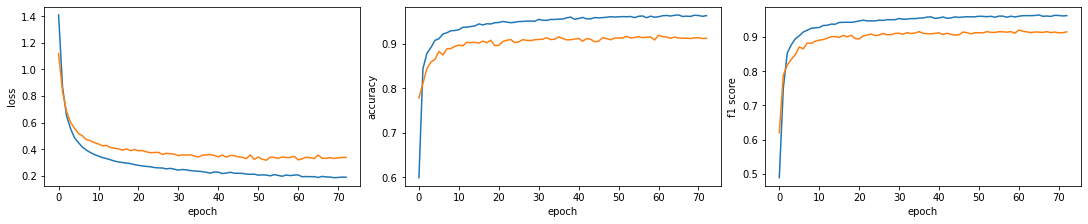

In [12]:
# 시각화
# 손실, 정확도 그래프
plt.subplots(figsize=(15, 3), constrained_layout=True)
plt.subplot(1, 3, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(fourth_side_model_after_data.history['loss'])
plt.plot(fourth_side_model_after_data.history['val_loss'])
plt.subplot(1, 3, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(fourth_side_model_after_data.history['accuracy'])
plt.plot(fourth_side_model_after_data.history['val_accuracy'])
plt.subplot(1, 3, 3)
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.plot(fourth_side_model_after_data.history['f1_m'])
plt.plot(fourth_side_model_after_data.history['val_f1_m'])

plt.show()


In [13]:
# 5번째 모델 구성 (multi-class classification)
# 1층, 노드 (64)
dropout_ratio = 0.5
regulation = 0.01

fifth_side_model = Sequential()

fifth_side_model.add(Dense(128, activation='relu', input_shape=(col,), kernel_regularizer=regularizers.l2(regulation)))
# fifth_side_model.add(Dropout(dropout_ratio))
fifth_side_model.add(Dense(128, activation='relu', input_shape=(col,), kernel_regularizer=regularizers.l2(regulation)))
# fifth_side_model.add(Dropout(dropout_ratio))
fifth_side_model.add(Dense(5, activation='softmax'))

# 모델 최적화 및 손실 함수 알고리즘 지정
# adam, crossentropy
fifth_side_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', recall_m, precision_m, f1_m])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)
save_best = keras.callbacks.ModelCheckpoint(filepath='trained_models/side_exp/fall_model_five_class_fourth_exp.h5', verbose=1, save_best_only=True, mode='auto', save_freq='epoch')

# 모델 training
fifth_side_model_after_data = fifth_side_model.fit(scaled_learn_x, learn_y, batch_size=64, epochs=300, validation_data=(scaled_valid_x, valid_y), callbacks=[early_stop, save_best])

# 모델 test (predict)
print()
predict_result = fifth_side_model.predict(scaled_test_x)
fifth_side_model.evaluate(scaled_test_x, test_y)
test_correct = 0
for i in range(len(test_y)):
    if test_y[i].argmax() == predict_result[i].argmax():
        test_correct += 1
print(f"test result correct percent : {test_correct/len(test_y) * 100:.2f}%")


Epoch 1/300
146/155 [===========================>..] - ETA: 0s - loss: 1.6621 - accuracy: 0.8292 - recall_m: 0.6893 - precision_m: 0.9343 - f1_m: 0.7689
Epoch 1: val_loss improved from inf to 1.07909, saving model to trained_models/side_exp/fall_model_five_class_fourth_exp.h5
155/155 [==============================] - 1s 2ms/step - loss: 1.6199 - accuracy: 0.8349 - recall_m: 0.7024 - precision_m: 0.9351 - f1_m: 0.7782 - val_loss: 1.0791 - val_accuracy: 0.8125 - val_recall_m: 0.7523 - val_precision_m: 0.8449 - val_f1_m: 0.7956
Epoch 2/300
 86/155 [===============>..............] - ETA: 0s - loss: 0.6829 - accuracy: 0.9511 - recall_m: 0.9377 - precision_m: 0.9647 - f1_m: 0.9509
Epoch 2: val_loss improved from 1.07909 to 0.65386, saving model to trained_models/side_exp/fall_model_five_class_fourth_exp.h5
155/155 [==============================] - 0s 840us/step - loss: 0.6084 - accuracy: 0.9536 - recall_m: 0.9421 - precision_m: 0.9652 - f1_m: 0.9534 - val_loss: 0.6539 - val_accuracy: 0.897

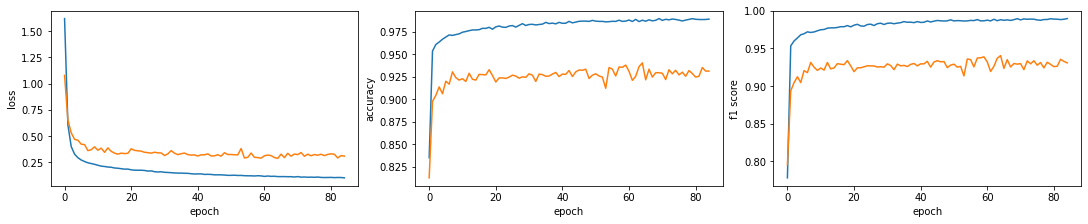

In [14]:
# 시각화
# 손실, 정확도 그래프
plt.subplots(figsize=(15, 3), constrained_layout=True)
plt.subplot(1, 3, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(fifth_side_model_after_data.history['loss'])
plt.plot(fifth_side_model_after_data.history['val_loss'])
plt.subplot(1, 3, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(fifth_side_model_after_data.history['accuracy'])
plt.plot(fifth_side_model_after_data.history['val_accuracy'])
plt.subplot(1, 3, 3)
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.plot(fifth_side_model_after_data.history['f1_m'])
plt.plot(fifth_side_model_after_data.history['val_f1_m'])

plt.show()
